## [1. Import Needed Modules](#import) ##
## [2 Concept for Callback Approach](#concept) ##
## [3. Define function to print text in rgb foreground and background colors](#pc) ##
## [4. Read in images and create a dataframe of image paths and class labels](#makedf) ## 
## [5. Trim the trainning set](#Balance) ##
## [6. Create train, test and validation generators](#generators) ## 
## [7. Create a function to show Training Image Samples](#show) ## 
## [8. Create the Model](#model) ## 
## [9. Create a custom Keras callback to continue or halt training](#callback) ## 
## [10. Instantiate custom callback ](#callbacks) ##
## [11. Train the model](#train) ##
## [12. Define a function to plot the training data](#plot) ##
## [13. Make predictions on test set, create Confusion Matrix and Classification Report](#result) ##
## [14 Save the model](#save) ##


<a id="import"></a>
# <center>Import Need Modules</center>

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from mtcnn.mtcnn import MTCNN
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('Modules are loaded')

Modules are loaded


<a id="pc"></a>

In [2]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



<a id="makedf"></a>
# <center>Read in train,  and test images, make validation set , create train_test and valid data frames

In [3]:
def make_dataframes(train_dir, test_dir):
    dirlist=[train_dir,  test_dir]
    names=['train', 'test']
    zipdir=zip(names, dirlist)
    
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )       
        for klass in classlist:
            classpath=os.path.join(d, klass)           
            flist=sorted(os.listdir(classpath)) 
            desc=f'{name:6s}-{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name =='test':
            test_df=df       
        else:
            pdf=df 
    # split pdf into a train_df and a test_df
    train_df, valid_df=train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

train_dir = r'face_archive/train'
test_dir=r'face_archive/test'
train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir, test_dir)
    

test  -children                 : 100%|████████████████████████████████████████████████████████████████| 53/53 [00:00<?, ?files/s]

number of classes in processed dataset=  2
the maximum files in any class in train_df is  278   the minimum files in any class in train_df is  250
train_df length:  528   test_df length:  112   valid_df length:  133
average image height=  350   average image width=  350  aspect ratio h/w=  1.0


In [4]:
working_dir=r'./'
img_size = (100,100)# reduce image size to speed up training


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [5]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=5
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)


Found 528 validated image filenames belonging to 2 classes.            for train generator 
Found 133 validated image filenames belonging to 2 classes.            for valid generator 
Found 112 validated image filenames belonging to 2 classes.            for test generator 
test batch size:  56   test steps:  2  number of classes :  2


<a id="show"></a>
# <center>Create a function to show example training images</center>

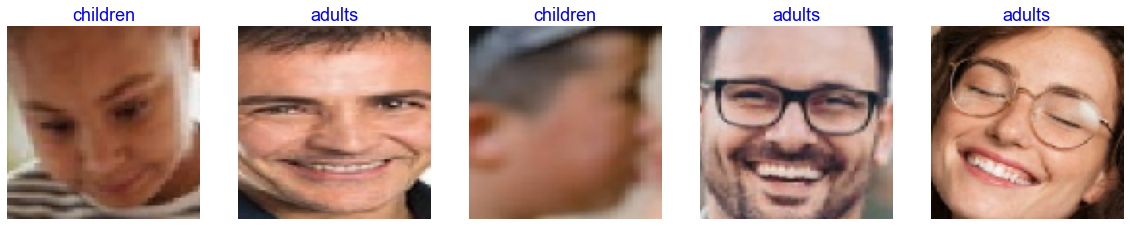

In [6]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Create a model using transfer learning with EfficientNetB3</center>
### NOTE experts advise you make the base model initially not trainable when you do transfer learning.   
### Then train for some number of epochs then fine tune model by making base model trainable and run more epochs
### I have found this to be WRONG!!!!
### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
### for the same number of total epochs! Insure  you initialize the transfer model with imagenet weights

In [7]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default

Created EfficientNet B3 model with initial learning rate set to 0.001



<a id="callback"></a>
# <center>Create a custom Keras callback to continue and optionally set LR or halt training</center>
The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.  
If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to  
enter a new value for the learning rate. The form of use is:  
ask=LR_ASK(model,epochs, ask_epoch) where:  
* model is a string which is the name of your compiled model
* epochs is an integer which is the number of epochs to run specified in model.fit
* ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs.  
  then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4  
  training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an  
  integer value you are prompted to press ENTER to continue training using the current learning rate  
  or to enter a new value for the learning rate.
 * dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest   
   validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate  
   is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation  
   here is that if the validatio loss increased we have moved to a point in Nspace on the cost functiob surface that  
   if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights
   from the epoch with the lowest loss and the learning rate is reduced
  
 At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss

In [8]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} loading weights from epoch {str(self.best_epoch)} as model weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

<a id="callbacks"></a>
# <center>Instantiate custom callback 

In [9]:
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

<a id="train"></a>
# <center>Train the model
### Note unlike how you are told it is BETTER to make the base model trainable from the outset if you are doing transfer learning
### The model will converge faster and have a lower validation losss. Ensure you initialize the transfer model with imagenet weights.  
### I have done a lot of testing running both ways hand have always found this to be true

In [10]:

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
106/106 [==============================] - ETA: 0s - loss: 8.0066 - accuracy: 0.6439
 validation loss of  7.9057 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

106/106 [==============================] - 28s 153ms/step - loss: 8.0066 - accuracy: 0.6439 - val_loss: 7.9057 - val_accuracy: 0.6842
Epoch 2/40
106/106 [==============================] - ETA: 0s - loss: 6.5953 - accuracy: 0.7708
 validation loss of  6.1249 is 22.5252 % below lowest loss, saving weights from epoch 2   as best weights

106/106 [==============================] - 13s 123ms/step - loss: 6.5953 - accuracy: 0.7708 - val_loss: 6.1249 - val_accuracy: 0.7970
Epoch 3/40
106/106 [==============================] - ETA: 0s - loss: 5.8729 - accuracy: 0.7311
 valid

 5


you entered 5 Training will continue to epoch 15

106/106 [==============================] - 18s 168ms/step - loss: 2.4276 - accuracy: 0.8939 - val_loss: 2.3586 - val_accuracy: 0.8722
Epoch 11/40
106/106 [==============================] - ETA: 0s - loss: 2.1335 - accuracy: 0.9186
 validation loss of  2.2367 is  5.1652 % below lowest loss, saving weights from epoch 11  as best weights

106/106 [==============================] - 13s 124ms/step - loss: 2.1335 - accuracy: 0.9186 - val_loss: 2.2367 - val_accuracy: 0.8496
Epoch 12/40
106/106 [==============================] - ETA: 0s - loss: 1.9030 - accuracy: 0.9223
 validation loss of  1.9993 is 10.6137 % below lowest loss, saving weights from epoch 12  as best weights

106/106 [==============================] - 13s 123ms/step - loss: 1.9030 - accuracy: 0.9223 - val_loss: 1.9993 - val_accuracy: 0.8120
Epoch 13/40
106/106 [==============================] - ETA: 0s - loss: 1.8006 - accuracy: 0.8750
 validation loss of  1.8027 is  9.8345 % be

 5


you entered 5 Training will continue to epoch 20

106/106 [==============================] - 17s 159ms/step - loss: 1.4346 - accuracy: 0.9167 - val_loss: 1.4927 - val_accuracy: 0.8947
Epoch 16/40
106/106 [==============================] - ETA: 0s - loss: 1.2774 - accuracy: 0.9337
 validation loss of  1.4175 is  5.0407 % below lowest loss, saving weights from epoch 16  as best weights

106/106 [==============================] - 13s 125ms/step - loss: 1.2774 - accuracy: 0.9337 - val_loss: 1.4175 - val_accuracy: 0.8571
Epoch 17/40
106/106 [==============================] - ETA: 0s - loss: 1.2150 - accuracy: 0.9148
 validation loss of  1.2525 is 11.6380 % below lowest loss, saving weights from epoch 17  as best weights

106/106 [==============================] - 13s 125ms/step - loss: 1.2150 - accuracy: 0.9148 - val_loss: 1.2525 - val_accuracy: 0.8722
Epoch 18/40
106/106 [==============================] - ETA: 0s - loss: 1.1191 - accuracy: 0.9280
 validation loss of  1.2667 is  1.1338 % ab

 5


you entered 5 Training will continue to epoch 25

106/106 [==============================] - 17s 161ms/step - loss: 1.0326 - accuracy: 0.9602 - val_loss: 1.1788 - val_accuracy: 0.8346
Epoch 21/40
106/106 [==============================] - ETA: 0s - loss: 1.0377 - accuracy: 0.9375
 validation loss of  1.1255 is  4.5241 % below lowest loss, saving weights from epoch 21  as best weights

106/106 [==============================] - 13s 124ms/step - loss: 1.0377 - accuracy: 0.9375 - val_loss: 1.1255 - val_accuracy: 0.8647
Epoch 22/40
106/106 [==============================] - ETA: 0s - loss: 0.9482 - accuracy: 0.9545
 validation loss of  1.0756 is  4.4342 % below lowest loss, saving weights from epoch 22  as best weights

106/106 [==============================] - 13s 126ms/step - loss: 0.9482 - accuracy: 0.9545 - val_loss: 1.0756 - val_accuracy: 0.9023
Epoch 23/40
106/106 [==============================] - ETA: 0s - loss: 0.9148 - accuracy: 0.9527
 validation loss of  1.0375 is  3.5367 % be

 5


you entered 5 Training will continue to epoch 30

106/106 [==============================] - 16s 155ms/step - loss: 0.8554 - accuracy: 0.9508 - val_loss: 0.9706 - val_accuracy: 0.8722
Epoch 26/40
106/106 [==============================] - ETA: 0s - loss: 0.7738 - accuracy: 0.9830
 validation loss of  0.9411 is  3.0474 % below lowest loss, saving weights from epoch 26  as best weights

106/106 [==============================] - 14s 126ms/step - loss: 0.7738 - accuracy: 0.9830 - val_loss: 0.9411 - val_accuracy: 0.8797
Epoch 27/40
106/106 [==============================] - ETA: 0s - loss: 0.7734 - accuracy: 0.9602
 validation loss of  0.8950 is  4.8926 % below lowest loss, saving weights from epoch 27  as best weights

106/106 [==============================] - 13s 123ms/step - loss: 0.7734 - accuracy: 0.9602 - val_loss: 0.8950 - val_accuracy: 0.9023
Epoch 28/40
106/106 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.9716
 validation loss of  0.8808 is  1.5898 % be

 5


you entered 5 Training will continue to epoch 35

106/106 [==============================] - 16s 147ms/step - loss: 0.6785 - accuracy: 0.9716 - val_loss: 0.8383 - val_accuracy: 0.9173
Epoch 31/40
106/106 [==============================] - ETA: 0s - loss: 0.6444 - accuracy: 0.9754
 validation loss of  0.8504 is  1.4449 % above lowest loss of  0.8383 loading weights from epoch 30 as model weights

learning rate was automatically adjusted from 0.000400 to 0.000160, model weights set to best weights

106/106 [==============================] - 13s 125ms/step - loss: 0.6444 - accuracy: 0.9754 - val_loss: 0.8504 - val_accuracy: 0.8872
Epoch 32/40
106/106 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.9697
 validation loss of  0.8496 is  1.3480 % above lowest loss of  0.8383 loading weights from epoch 30 as model weights

learning rate was automatically adjusted from 0.000160 to 0.000064, model weights set to best weights

106/106 [==============================] - 13s

 h


you entered h,  Training halted on epoch 35 due to user input


106/106 [==============================] - 16s 146ms/step - loss: 0.6650 - accuracy: 0.9659 - val_loss: 0.8466 - val_accuracy: 0.9023
loading model with weights from epoch 30

training elapsed time was 0.0 hours,  8.0 minutes, 18.85 seconds)



<a id="plot"></a>
# <center>Define a function to plot the training data

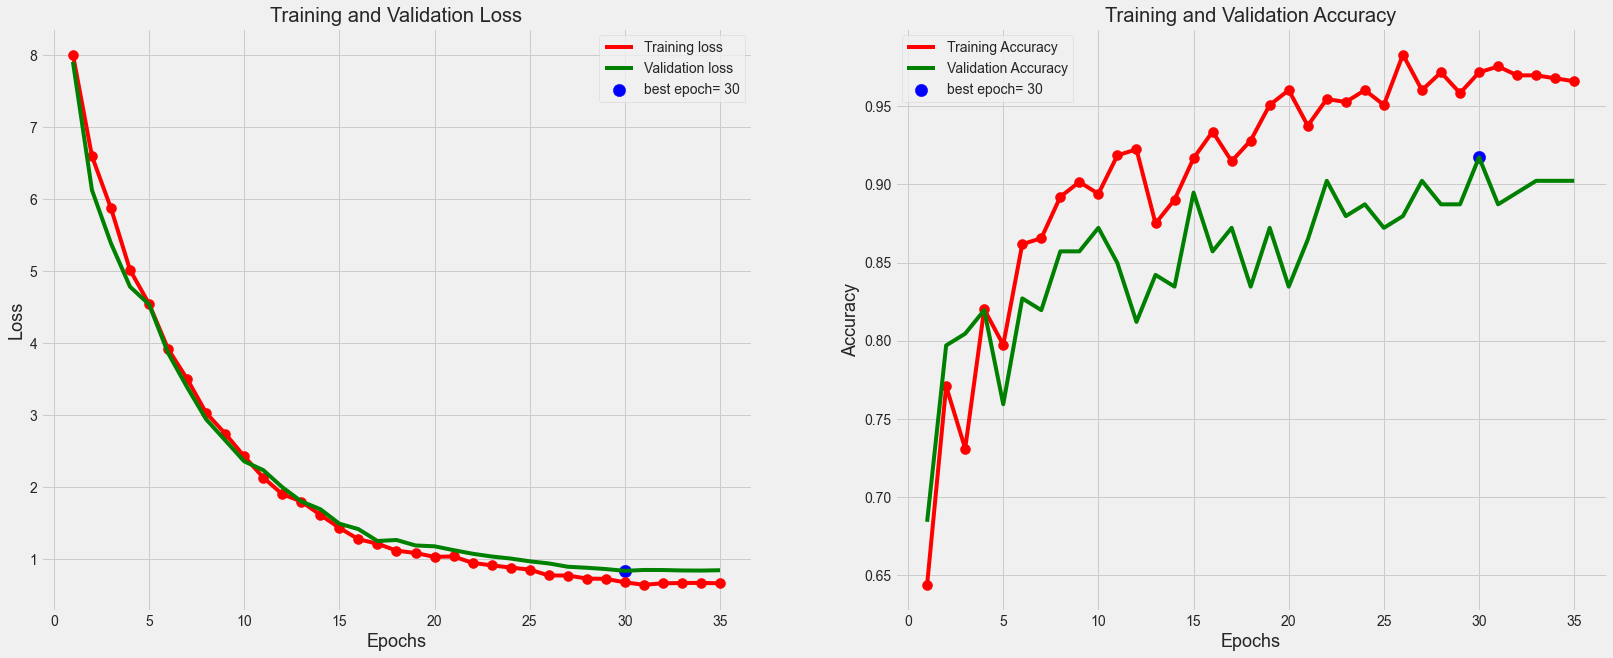

In [11]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')    
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

<a id="result"></a>
# <center>Make Predictions on the test set</a>
### Define a function which takes in a test generator and an integer test_steps
### and generates predictions on the test set including a confusion matric
### and a classification report

2/2 [==============================] - 3s 22ms/step
there were 18 errors in 112 tests for an accuracy of  83.93



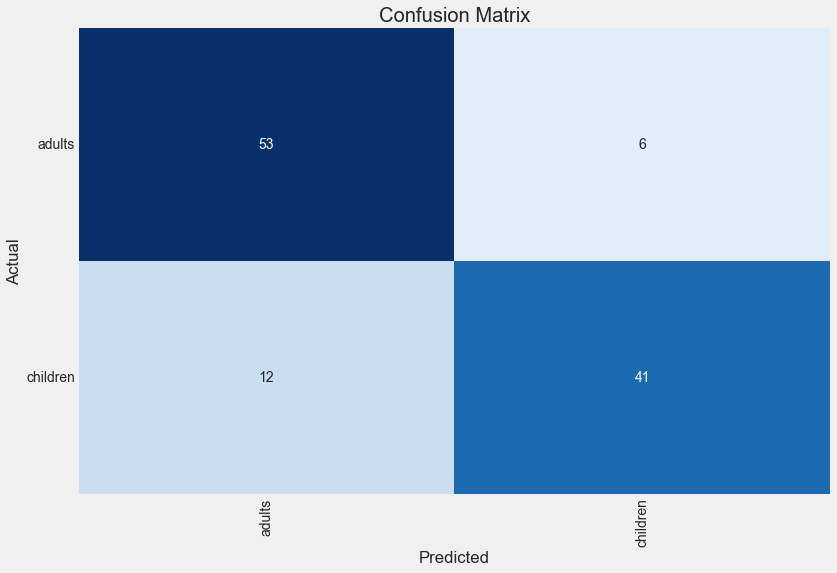

Classification Report:
----------------------
               precision    recall  f1-score   support

      adults     0.8154    0.8983    0.8548        59
    children     0.8723    0.7736    0.8200        53

    accuracy                         0.8393       112
   macro avg     0.8439    0.8359    0.8374       112
weighted avg     0.8423    0.8393    0.8384       112



In [12]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):  
        file=test_gen.filenames[i]        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
            error_class=classes[pred_index]
            t=(file, error_class)
            error_list.append(t)            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, f1score

errors, tests, error_list, f1score =predictor(test_gen)

<a id="save"></a>
# <center>Save the model

In [13]:

subject='adult ot child' 
save_id=f'{subject}-{f1score:5.2f}.h5'
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
msg= f'model was saved as {model_save_loc}'
print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground

model was saved as ./adult ot child-83.84.h5

